# COMP0124: Multi-Agent Artificial Intelligence

# Group project: Real-time bidding auctions

**Group #7: Oliviero Balbinetti, Mauricio Caballero, Paul Melkert**

Importing libraries.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import collections as coll
import matplotlib.pyplot as plt

from glob import glob
from scipy import stats
from IPython.display import display

Importing data in pandas DataFrames.

In [2]:
#Defining directory.
Path = '/Users/olivierobalbinetti/Desktop/University College London/Term 2'\
       '/Multi Agents Artificial Intelligence/Courseworks/Group coursework/'\
       'Data'

#Importing data.
Datasets = {}
os.chdir(Path)

for Filename in glob('*.csv'):
    Datasets[Filename[:-4].title()] = pd.read_csv(Filename, sep = ',')
    
#Defining variables.
Test = Datasets['Test']
Train = Datasets['Train']
Validation = Datasets['Validation']
Total_data = sum([len(Datasets[key]) for key in Datasets.keys()])

#Feature engineering: ad exchange.
Test['adexchange'] = Test['adexchange'].fillna('nan')
Train['adexchange'] = Train['adexchange'].fillna('nan')
Validation['adexchange'] = Validation['adexchange'].fillna('nan')

#Feature engineering: slot size.
Test['slotsize'] = Test['slotwidth'].astype('str') + '*' + Test['slotheight'].astype('str')
Train['slotsize'] = Train['slotwidth'].astype('str') + '*' + Train['slotheight'].astype('str')
Validation['slotsize'] = Validation['slotwidth'].astype('str') + '*' + Validation['slotheight'].astype('str')

#Feature engineering: browser user agent.
Temp = Train['useragent'].str.split('_', n=1, expand=True)
Train['OS'] = Temp[0]
Train['Browser'] = Temp[1]

Temp = Test['useragent'].str.split('_', n=1, expand=True)
Test['OS'] = Temp[0]
Test['Browser'] = Temp[1]

Temp = Validation['useragent'].str.split('_', n=1, expand=True)
Validation['OS'] = Temp[0]
Validation['Browser'] = Temp[1]

#Feature engineering: user tags.
Train['usertag'] = Train['usertag'].fillna('nan')
Train['usertag list'] = Train['usertag'].str.split(',').values
Tags = [item for sublist in list(Train['usertag list'].values) for item in sublist]
dct = dict(coll.Counter(Tags).most_common())
dct['nan'] = max(dct.values())+1
dct = dict(sorted(dct.items(), key=lambda kv: kv[1], reverse=True))
dct = dict(enumerate(dct.keys()))
dct = {value:key for key,value in dct.items()}
dct['nan'] = 'nan'
Train = Train.assign(mapped=[[dct[k] for k in row if dct.get(k)] for row in Train['usertag list'].values])

Test['usertag'] = Test['usertag'].fillna('nan')
Test['usertag list'] = Test['usertag'].str.split(',').values
Tags = [item for sublist in list(Test['usertag list'].values) for item in sublist]
dct = dict(coll.Counter(Tags).most_common())
dct['nan'] = max(dct.values())+1
dct = dict(sorted(dct.items(), key=lambda kv: kv[1], reverse=True))
dct = dict(enumerate(dct.keys()))
dct = {value:key for key,value in dct.items()}
dct['nan'] = 'nan'
Test = Test.assign(mapped=[[dct[k] for k in row if dct.get(k)] for row in Test['usertag list'].values])

Validation['usertag'] = Validation['usertag'].fillna('nan')
Validation['usertag list'] = Validation['usertag'].str.split(',').values
Tags = [item for sublist in list(Validation['usertag list'].values) for item in sublist]
dct = dict(coll.Counter(Tags).most_common())
dct['nan'] = max(dct.values())+1
dct = dict(sorted(dct.items(), key=lambda kv: kv[1], reverse=True))
dct = dict(enumerate(dct.keys()))
dct = {value:key for key,value in dct.items()}
dct['nan'] = 'nan'
Validation = Validation.assign(mapped=[[dct[k] for k in row if dct.get(k)] 
                                       for row in Validation['usertag list'].values])

#Feature engineering: renaming.
Test = Test.rename(columns={'mapped':'tagcodes'})
Train = Train.rename(columns={'mapped':'tagcodes'})
Validation = Validation.rename(columns={'mapped':'tagcodes'})

High level study of DataFrame.

In [3]:
#Amount of data.
print('High level study of datasets:\n')
print('Data exploration - datasets structure:')

for key in Datasets.keys():
    print('\n• ' + key + ' dataset:')
    
    dataframe = Datasets[key]
    print(' - Amount of data: %d.' %len(dataframe))
    print(' - Percentage of data (total): %.2f%%.'
          %(len(dataframe)/Total_data*100))
    print(' - Number of columns: %d.' %len(dataframe.columns))
    print(' - Column names:', *dataframe.columns, sep=' ')
    
#Data description.
print('\nData exploration - columns description:\n')

print('• click: [0,1] variable describing feebacks (1 if clicked).')
print('• weekday: [0,1,..,6] variable describing week days.')
print('• hour: [0,1,..,23] variable describing day hours.')
print('• bidid: alphanumeric string identifying each single event.')
print('• userid: alphanumeric string identifying each single user.')
print('• useragent: string containing browser user agent used (splitted).')
print('• IP: string containing first three bytes of user IP address.')
print('• region: province or state numeric ID where the user visits from.')
print('• city: city numeric ID where the user visits from.')
print('• adexchange: [nan,1,2,3,4] variable identifying ad exchange.')
print('• domain: alphanumeric string identifying hosting webpage domain.')
print('• url: alphanumeric string identifying URL (avail. to DPS).')
print('• urlid: alphanumeric string identifying URL (prov. by ad exchange).')
print('• slotid: unique ID identifying ad impression location on web page.')
print('• slotwidth: variable representing the width of the slot.')
print('• slotheight: variable representing the height of the slot.')
print('• slotvisibility: string identifying slot position wrt the fold.')
print('• slotformat: variable representing slot types.')
print('• slotprice: variable representing slot reserve price.')
print('• creative: alphanumeric string identifying advertiser ad creative.')
print('• bidprice: variable describing price DSP bids.')
print('• payprice: variable describing price DSP pays on winning.')
print('• keypage: alphanumeric string identifying main page URL.')
print('• advertiser: unique ID identifying advertisers.')
print('• usertag: variable containing list of tags describing each user.')

#Advertiser description.
print('\nData exploration - advertisers description:\n')

print('• [Advertiser ID: 1458]: Industry: Chinese vertical e-commerce.')
print('• [Advertiser ID: 2259]: Industry: Milk powder.')
print('• [Advertiser ID: 2261]: Industry: Telecom.')
print('• [Advertiser ID: 2821]: Industry: Footwear.')
print('• [Advertiser ID: 2997]: Industry: Mobile e-commerce app install.')
print('• [Advertiser ID: 3358]: Industry: Software.')
print('• [Advertiser ID: 3386]: Industry: International e-commerce.')
print('• [Advertiser ID: 3427]: Industry: Oil.')
print('• [Advertiser ID: 3476]: Industry: Tire.')

High level study of datasets:

Data exploration - datasets structure:

• Validation dataset:
 - Amount of data: 303925.
 - Percentage of data (total): 10.00%.
 - Number of columns: 29.
 - Column names: click weekday hour bidid userid useragent IP region city adexchange domain url urlid slotid slotwidth slotheight slotvisibility slotformat slotprice creative bidprice payprice keypage advertiser usertag slotsize OS Browser usertag list

• Test dataset:
 - Amount of data: 303375.
 - Percentage of data (total): 9.99%.
 - Number of columns: 26.
 - Column names: weekday hour bidid userid useragent IP region city adexchange domain url urlid slotid slotwidth slotheight slotvisibility slotformat slotprice creative keypage advertiser usertag slotsize OS Browser usertag list

• Train dataset:
 - Amount of data: 2430981.
 - Percentage of data (total): 80.01%.
 - Number of columns: 29.
 - Column names: click weekday hour bidid userid useragent IP region city adexchange domain url urlid slotid slotw

Descriptive analytics.

In [4]:
#Advertiser statistics.
Advs = dict(enumerate(sorted(set(Train['advertiser'].values))))
Advs = {value:key for key,value in Advs.items()}

Train_statistics = []
Matrix_train = np.zeros((len(Advs),7))

Validation_statistics = []
Matrix_validation = np.zeros((len(Advs),7))

#Loping on advertisers.
for adv in Advs.keys():
    
    #Train set analysis.
    data = Train[Train['advertiser'] == adv]
    Matrix_train[Advs[adv],0] = adv
    Matrix_train[Advs[adv],1] = len(data)
    Matrix_train[Advs[adv],2] = sum(data['click'])
    Matrix_train[Advs[adv],3] = sum(data['payprice'])/1000
    Matrix_train[Advs[adv],4] = sum(data['click'])/len(data)*100
    Matrix_train[Advs[adv],5] = np.mean(data['payprice'])
    Matrix_train[Advs[adv],6] = sum(data['payprice'])/(sum(data['click'])*1000)
    
    #Validation set analysis.
    data = Validation[Validation['advertiser'] == adv]
    Matrix_validation[Advs[adv],0] = adv
    Matrix_validation[Advs[adv],1] = len(data)
    Matrix_validation[Advs[adv],2] = sum(data['click'])
    Matrix_validation[Advs[adv],3] = sum(data['payprice'])/1000
    Matrix_validation[Advs[adv],4] = sum(data['click'])/len(data)*100
    Matrix_validation[Advs[adv],5] = np.mean(data['payprice'])
    Matrix_validation[Advs[adv],6] = sum(data['payprice'])/(sum(data['click'])*1000)
    
#Overall statistics.
Train_statistics.append(np.mean(Matrix_train, axis=0))
Train_statistics.append(stats.sem(Matrix_train, axis=0))
Train_statistics.append(np.std(Matrix_train, axis=0))
Train_statistics.append(stats.skew(Matrix_train, axis=0))
Train_statistics.append(stats.kurtosis(Matrix_train, axis=0, fisher=True))
Train_statistics.append(np.sum(Matrix_train, axis=0))

Validation_statistics.append(np.mean(Matrix_validation, axis=0))
Validation_statistics.append(stats.sem(Matrix_validation, axis=0))
Validation_statistics.append(np.std(Matrix_validation, axis=0))
Validation_statistics.append(stats.skew(Matrix_validation, axis=0))
Validation_statistics.append(stats.kurtosis(Matrix_validation, axis=0, fisher=True))
Validation_statistics.append(np.sum(Matrix_validation, axis=0))

#Printing results.
Df_train_advs = pd.DataFrame(Matrix_train, 
                             columns=['Adv code', 'Imps', 'Clicks', 'Cost', 'CTR (%)', 'avg CPM', 'eCPC'])

Df_validation_advs = pd.DataFrame(Matrix_validation, 
                                  columns=['Adv code', 'Imps', 'Clicks', 'Cost', 'CTR (%)', 'avg CPM', 'eCPC'])

Df_train_stats = pd.DataFrame(np.array(Train_statistics)[:,1:],
                              index=['Mean', 'Std err','Std', 'Skew', 'Kurt', 'Total'],
                              columns=['Imps', 'Clicks', 'Cost', 'CTR', 'avg CPM', 'eCPC'])

Df_validation_stats = pd.DataFrame(np.array(Validation_statistics)[:,1:],
                                   index=['Mean', 'Std err','Std', 'Skew', 'Kurt', 'Total'],
                                   columns=['Imps', 'Clicks', 'Cost', 'CTR', 'avg CPM', 'eCPC'])

print('Descriptive analytics:\n')
print('Total number of advertisers in datasets: %d.\n' %len(Advs))

print('• Train set:\n')
print(' - Advertisers statistics:')
Df_train_advs['Imps'] = Df_train_advs['Imps'].astype('int64')
Df_train_advs['Clicks'] = Df_train_advs['Clicks'].astype('int64')
Df_train_advs['Adv code'] = Df_train_advs['Adv code'].astype('int64')
display(Df_train_advs)

print('\n - Summarization statistics:')
display(Df_train_stats)

print('\n• Validation set:\n')
print(' - Advertisers statistics:')
Df_validation_advs['Imps'] = Df_validation_advs['Imps'].astype('int64')
Df_validation_advs['Clicks'] = Df_validation_advs['Clicks'].astype('int64')
Df_validation_advs['Adv code'] = Df_validation_advs['Adv code'].astype('int64')
display(Df_validation_advs)

print('\n - Summarization statistics:')
display(Df_validation_stats)

Descriptive analytics:

Total number of advertisers in datasets: 9.

• Train set:

 - Advertisers statistics:


,Adv code,Imps,Clicks,Cost,CTR (%),avg CPM,eCPC
0,1458,492353,385,33968.736,0.078196,68.992646,88.230483
1,2259,133673,43,12428.238,0.032168,92.974931,289.028791
2,2261,110122,36,9873.779,0.032691,89.662184,274.271639
3,2821,211366,131,18828.044,0.061978,89.077922,143.725527
4,2997,49829,217,3129.267,0.435489,62.800116,14.420585
5,3358,264956,202,22447.231,0.076239,84.720599,111.124906
6,3386,455041,320,34931.823,0.070323,76.766320,109.161947
7,3427,402806,272,30458.711,0.067526,75.616329,111.980555
8,3476,310835,187,23918.779,0.060161,76.950083,127.907909



 - Summarization statistics:


,Imps,Clicks,Cost,CTR,avg CPM,eCPC
Mean,2.701090e+05,199.222222,21109.400889,0.101641,79.729014,141.094705
Std err,5.258202e+04,39.188213,3696.104254,0.042109,3.378263,29.204234
Std,1.487244e+05,110.841005,10454.161527,0.119103,9.555171,82.602048
Skew,7.362105e-02,0.006875,-0.222513,2.388079,-0.249707,0.657020
Kurt,-1.344370e+00,-0.968870,-1.160793,3.889158,-1.072309,-0.466801
Total,2.430981e+06,1793.000000,189984.608000,0.914771,717.561129,1269.852342



• Validation set:

 - Advertisers statistics:


,Adv code,Imps,Clicks,Cost,CTR (%),avg CPM,eCPC
0,1458,62353,49,4294.602,0.078585,68.875627,87.644939
1,2259,16715,2,1568.808,0.011965,93.856297,784.404000
2,2261,13550,3,1214.876,0.022140,89.658745,404.958667
3,2821,26503,23,2394.900,0.086783,90.363355,104.126087
4,2997,6176,26,388.784,0.420984,62.950777,14.953231
5,3358,32939,23,2794.021,0.069826,84.824099,121.479174
6,3386,56665,28,4350.793,0.049413,76.780958,155.385464
7,3427,50183,37,3776.735,0.073730,75.259251,102.073919
8,3476,38841,11,2993.751,0.028321,77.077083,272.159182



 - Summarization statistics:


,Imps,Clicks,Cost,CTR,avg CPM,eCPC
Mean,33769.444444,22.444444,2641.918889,0.093527,79.960688,227.464962
Std err,6615.344780,5.121065,462.661297,0.041899,3.479610,79.561069
Std,18711.020615,14.484560,1308.603761,0.118508,9.841824,225.032686
Skew,0.089679,0.169344,-0.227206,2.257711,-0.187397,1.566780
Kurt,-1.323153,-0.783411,-1.146742,3.529343,-1.130329,1.344231
Total,303925.000000,202.000000,23777.270000,0.841747,719.646194,2047.184662


Trend analysis.

In [7]:
#Trend analysis.
print('Trend analysis:\n')
Ref = {'CTR':0, 'CPM':1, 'eCPC':2}

#Initialising references.
Dict_OS = {}
Dict_brw = {}
Dict_day = {}
Dict_reg = {}
Dict_tag = {}
Dict_hour = {}
Dict_adexc = {}
Dict_sltsz = {}

#Initialising values.
Matrix_OS = {}
Matrix_brw = {}
Matrix_day = {}
Matrix_reg = {}
Matrix_tag = {}
Matrix_hour = {}
Matrix_adexc = {}
Matrix_sltsz = {}

#Initialising errors.
Matrix_OS_err = {}
Matrix_brw_err = {}
Matrix_day_err = {}
Matrix_reg_err = {}
Matrix_tag_err = {}
Matrix_hour_err = {}
Matrix_adexc_err = {}
Matrix_sltsz_err = {}

#Loping on advertisers.
for adv in Advs.keys():
    
    #Selecting data.
    data = Train[Train['advertiser'] == adv]
    
    #Analyzing tags.
    Tags = set([item for sublist in list(data['usertag list'].values) for item in sublist])
    Tags.remove('nan')
    
    Dict_tag[adv] = {value:key for key,value in dict(enumerate(Tags)).items()}
    Matrix_tag[adv] = np.zeros((3,len(Dict_tag[adv])))
    Matrix_tag_err[adv] = np.zeros((2,len(Dict_tag[adv])))
    
    for tag in Dict_tag[adv].keys():
        df = data[data['usertag'].str.contains(tag)]
        
        Matrix_tag[adv][Ref['CPM'],Dict_tag[adv][tag]] = np.mean(df['payprice'])
        Matrix_tag[adv][Ref['CTR'],Dict_tag[adv][tag]] = np.mean(df['click'])*100
        Matrix_tag[adv][Ref['eCPC'],Dict_tag[adv][tag]] = sum(df['payprice'])/\
                                                          (max(sum(df['click']),1e-6)*1000)
        
        Matrix_tag_err[adv][Ref['CPM'],Dict_tag[adv][tag]] = stats.sem(df['payprice'])
        Matrix_tag_err[adv][Ref['CTR'],Dict_tag[adv][tag]] = stats.sem(df['click'])*100
        
    #Analyzing operating systems.
    Dict_OS[adv] = {value:key for key,value in dict(enumerate(sorted(set(data['OS'])))).items()}    
    Matrix_OS[adv] = np.zeros((3,len(Dict_OS[adv])))
    Matrix_OS_err[adv] = np.zeros((2,len(Dict_OS[adv])))
    
    for OS, df in data.groupby(by='OS', axis=0):
        Matrix_OS[adv][Ref['CPM'],Dict_OS[adv][OS]] = np.mean(df['payprice'])
        Matrix_OS[adv][Ref['CTR'],Dict_OS[adv][OS]] = np.mean(df['click'])*100
        Matrix_OS[adv][Ref['eCPC'],Dict_OS[adv][OS]] = sum(df['payprice'])/(max(sum(df['click']),1e-6)*1000)
        
        Matrix_OS_err[adv][Ref['CPM'],Dict_OS[adv][OS]] = stats.sem(df['payprice'])
        Matrix_OS_err[adv][Ref['CTR'],Dict_OS[adv][OS]] = stats.sem(df['click'])*100
        
    #Analyzing daily hours.
    Dict_hour[adv] = {value:key for key,value in dict(enumerate(sorted(set(data['hour'])))).items()}    
    Matrix_hour[adv] = np.zeros((3,len(Dict_hour[adv])))
    Matrix_hour_err[adv] = np.zeros((2,len(Dict_hour[adv])))
    
    for hour, df in data.groupby(by='hour', axis=0):
        Matrix_hour[adv][Ref['CPM'],Dict_hour[adv][hour]] = np.mean(df['payprice'])
        Matrix_hour[adv][Ref['CTR'],Dict_hour[adv][hour]] = np.mean(df['click'])*100
        Matrix_hour[adv][Ref['eCPC'],Dict_hour[adv][hour]] = sum(df['payprice'])/\
                                                             (max(sum(df['click']),1e-6)*1000)
        
        Matrix_hour_err[adv][Ref['CPM'],Dict_hour[adv][hour]] = stats.sem(df['payprice'])
        Matrix_hour_err[adv][Ref['CTR'],Dict_hour[adv][hour]] = stats.sem(df['click'])*100
        
    #Analyzing regions.
    Dict_reg[adv] = {value:key for key,value in dict(enumerate(sorted(set(data['region'])))).items()}    
    Matrix_reg[adv] = np.zeros((3,len(Dict_reg[adv])))
    Matrix_reg_err[adv] = np.zeros((2,len(Dict_reg[adv])))
    
    for reg, df in data.groupby(by='region', axis=0):
        Matrix_reg[adv][Ref['CPM'],Dict_reg[adv][reg]] = np.mean(df['payprice'])
        Matrix_reg[adv][Ref['CTR'],Dict_reg[adv][reg]] = np.mean(df['click'])*100
        Matrix_reg[adv][Ref['eCPC'],Dict_reg[adv][reg]] = sum(df['payprice'])/\
                                                          (max(sum(df['click']),1e-6)*1000)
        
        Matrix_reg_err[adv][Ref['CPM'],Dict_reg[adv][reg]] = stats.sem(df['payprice'])
        Matrix_reg_err[adv][Ref['CTR'],Dict_reg[adv][reg]] = stats.sem(df['click'])*100
        
    #Analyzing slot sizes.
    Dict_sltsz[adv] = {value:key for key,value in dict(enumerate(sorted(set(data['slotsize'])))).items()}    
    Matrix_sltsz[adv] = np.zeros((3,len(Dict_sltsz[adv])))
    Matrix_sltsz_err[adv] = np.zeros((2,len(Dict_sltsz[adv])))
    
    for sltsz, df in data.groupby(by='slotsize', axis=0):
        Matrix_sltsz[adv][Ref['CPM'],Dict_sltsz[adv][sltsz]] = np.mean(df['payprice'])
        Matrix_sltsz[adv][Ref['CTR'],Dict_sltsz[adv][sltsz]] = np.mean(df['click'])*100
        Matrix_sltsz[adv][Ref['eCPC'],Dict_sltsz[adv][sltsz]] = sum(df['payprice'])/\
                                                                (max(sum(df['click']),1e-6)*1000)
        
        Matrix_sltsz_err[adv][Ref['CPM'],Dict_sltsz[adv][sltsz]] = stats.sem(df['payprice'])
        Matrix_sltsz_err[adv][Ref['CTR'],Dict_sltsz[adv][sltsz]] = stats.sem(df['click'])*100
        
    #Analyzing browsers.
    Dict_brw[adv] = {value:key for key,value in dict(enumerate(sorted(set(data['Browser'])))).items()}    
    Matrix_brw[adv] = np.zeros((3,len(Dict_brw[adv])))
    Matrix_brw_err[adv] = np.zeros((2,len(Dict_brw[adv])))
    
    for brw, df in data.groupby(by='Browser', axis=0):
        Matrix_brw[adv][Ref['CPM'],Dict_brw[adv][brw]] = np.mean(df['payprice'])
        Matrix_brw[adv][Ref['CTR'],Dict_brw[adv][brw]] = np.mean(df['click'])*100
        Matrix_brw[adv][Ref['eCPC'],Dict_brw[adv][brw]] = sum(df['payprice'])/(max(sum(df['click']),1e-6)*1000)
        
        Matrix_brw_err[adv][Ref['CPM'],Dict_brw[adv][brw]] = stats.sem(df['payprice'])
        Matrix_brw_err[adv][Ref['CTR'],Dict_brw[adv][brw]] = stats.sem(df['click'])*100
        
    #Analyzing weekdays.
    Dict_day[adv] = {value:key for key,value in dict(enumerate(sorted(set(data['weekday'])))).items()}    
    Matrix_day[adv] = np.zeros((3,len(Dict_day[adv])))
    Matrix_day_err[adv] = np.zeros((2,len(Dict_day[adv])))
    
    for day, df in data.groupby(by='weekday', axis=0):
        Matrix_day[adv][Ref['CPM'],Dict_day[adv][day]] = np.mean(df['payprice'])
        Matrix_day[adv][Ref['CTR'],Dict_day[adv][day]] = np.mean(df['click'])*100
        Matrix_day[adv][Ref['eCPC'],Dict_day[adv][day]] = sum(df['payprice'])/(max(sum(df['click']),1e-6)*1000)
        
        Matrix_day_err[adv][Ref['CPM'],Dict_day[adv][day]] = stats.sem(df['payprice'])
        Matrix_day_err[adv][Ref['CTR'],Dict_day[adv][day]] = stats.sem(df['click'])*100
    
    #Analyzing ad exchanges.
    Dict_adexc[adv] = {value:key for key,value in dict(enumerate(sorted(set(data['adexchange'])))).items()}    
    Matrix_adexc[adv] = np.zeros((3,len(Dict_adexc[adv])))
    Matrix_adexc_err[adv] = np.zeros((2,len(Dict_adexc[adv])))
    
    for adexc, df in data.groupby(by='adexchange', axis=0):
        Matrix_adexc[adv][Ref['CPM'],Dict_adexc[adv][adexc]] = np.mean(df['payprice'])
        Matrix_adexc[adv][Ref['CTR'],Dict_adexc[adv][adexc]] = np.mean(df['click'])*100
        Matrix_adexc[adv][Ref['eCPC'],Dict_adexc[adv][adexc]] = sum(df['payprice'])/\
                                                                (max(sum(df['click']),1e-6)*1000)
        
        Matrix_adexc_err[adv][Ref['CPM'],Dict_adexc[adv][adexc]] = stats.sem(df['payprice'])
        Matrix_adexc_err[adv][Ref['CTR'],Dict_adexc[adv][adexc]] = stats.sem(df['click'])*100
        
    print('• [Advertiser: %d]: Precess completed!' %adv)

Trend analysis:

• [Advertiser: 1458]: Precess completed!
• [Advertiser: 2259]: Precess completed!
• [Advertiser: 2261]: Precess completed!
• [Advertiser: 2821]: Precess completed!
• [Advertiser: 2997]: Precess completed!
• [Advertiser: 3358]: Precess completed!
• [Advertiser: 3386]: Precess completed!
• [Advertiser: 3427]: Precess completed!
• [Advertiser: 3476]: Precess completed!


Printing results.

In [8]:
#Printing results.
Adv1 = 1458
Adv2 = 3358

Label1 = 'Advertiser: ' + str(Adv1)
Label2 = 'Advertiser: ' + str(Adv2)

print('Graphical results:\n')
print('• User feedbaks (CTR).')
print('• Bidding behaviour (Market price).')
print('• Expected cost per click (eCPC).')

Graphical results:

• User feedbaks (CTR).
• Bidding behaviour (Market price).
• Expected cost per click (eCPC).


User feedbaks (CTR).

• User feedbaks (CTR):



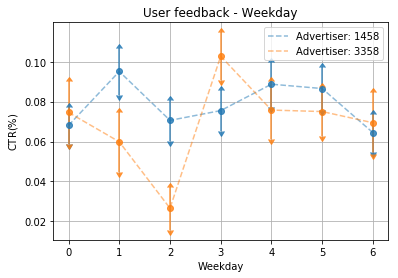

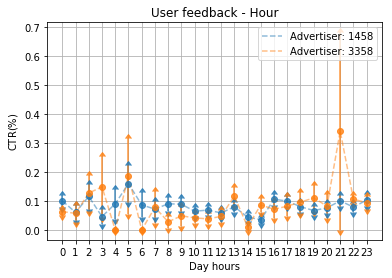

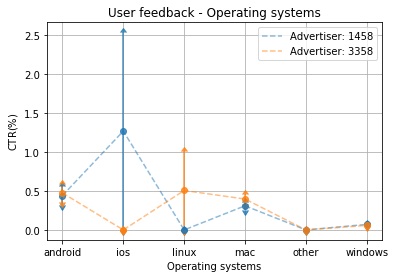

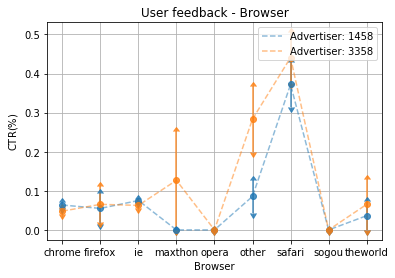

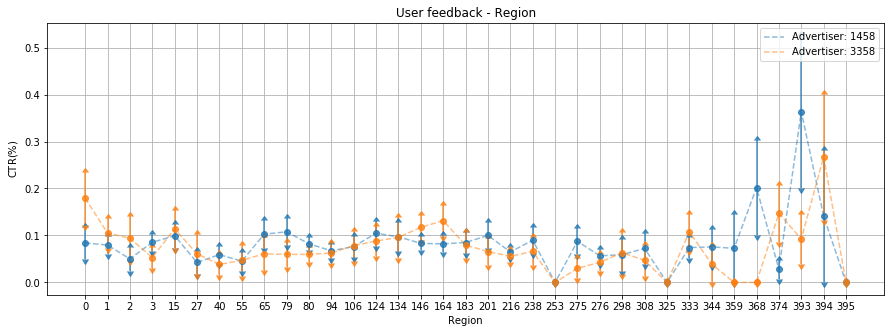

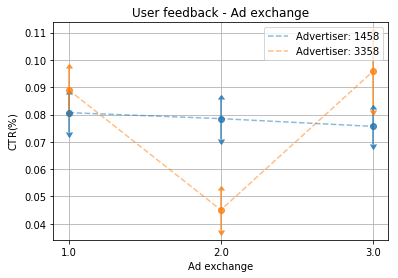

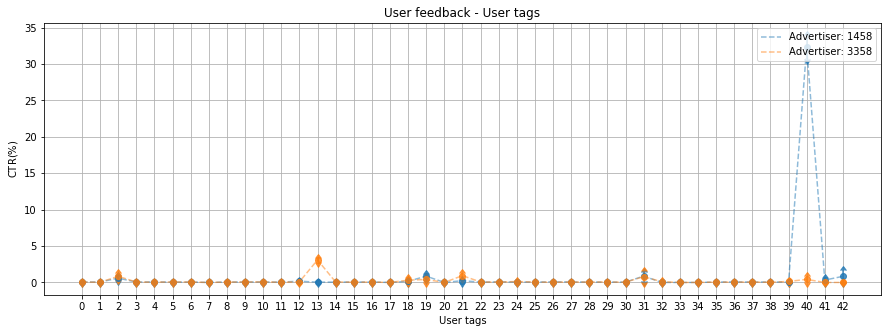

In [9]:
#User feedback (CTR).
print('• User feedbaks (CTR):\n')

#Weekday.
plt.title('User feedback - Weekday')
plt.xlabel('Weekday')
plt.ylabel('CTR($\%$)')

plt.errorbar(Dict_day[Adv1].values(), Matrix_day[Adv1][0], yerr=Matrix_day_err[Adv1][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_day[Adv1].values(), Matrix_day[Adv1][0], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_day[Adv2].values(), Matrix_day[Adv2][0], yerr=Matrix_day_err[Adv2][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_day[Adv2].values(), Matrix_day[Adv2][0], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_day[Adv1])), Dict_day[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Day hours.
plt.title('User feedback - Hour')
plt.xlabel('Day hours')
plt.ylabel('CTR($\%$)')

plt.errorbar(Dict_hour[Adv1].values(), Matrix_hour[Adv1][0], yerr=Matrix_hour_err[Adv1][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_hour[Adv1].values(), Matrix_hour[Adv1][0], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_hour[Adv2].values(), Matrix_hour[Adv2][0], yerr=Matrix_hour_err[Adv2][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_hour[Adv2].values(), Matrix_hour[Adv2][0], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_hour[Adv1])), Dict_hour[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Operating systems.
plt.title('User feedback - Operating systems')
plt.xlabel('Operating systems')
plt.ylabel('CTR($\%$)')

plt.errorbar(Dict_OS[Adv1].values(), Matrix_OS[Adv1][0], yerr=Matrix_OS_err[Adv1][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_OS[Adv1].values(), Matrix_OS[Adv1][0], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_OS[Adv2].values(), Matrix_OS[Adv2][0], yerr=Matrix_OS_err[Adv2][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_OS[Adv2].values(), Matrix_OS[Adv2][0], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_OS[Adv1])), Dict_OS[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Browser.
plt.title('User feedback - Browser')
plt.xlabel('Browser')
plt.ylabel('CTR($\%$)')

plt.errorbar(Dict_brw[Adv1].values(), Matrix_brw[Adv1][0], yerr=Matrix_brw_err[Adv1][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_brw[Adv1].values(), Matrix_brw[Adv1][0], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_brw[Adv2].values(), Matrix_brw[Adv2][0], yerr=Matrix_brw_err[Adv2][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_brw[Adv2].values(), Matrix_brw[Adv2][0], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_brw[Adv1])), Dict_brw[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Region.
plt.figure(figsize=(15,5))
plt.title('User feedback - Region')
plt.xlabel('Region')
plt.ylabel('CTR($\%$)')

plt.errorbar(Dict_reg[Adv1].values(), Matrix_reg[Adv1][0], yerr=Matrix_reg_err[Adv1][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_reg[Adv1].values(), Matrix_reg[Adv1][0], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_reg[Adv2].values(), Matrix_reg[Adv2][0], yerr=Matrix_reg_err[Adv2][0], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_reg[Adv2].values(), Matrix_reg[Adv2][0], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_reg[Adv1])), Dict_reg[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Slot ad exchange.
plt.title('User feedback - Ad exchange')
plt.xlabel('Ad exchange')
plt.ylabel('CTR($\%$)')

plt.errorbar(Dict_adexc[Adv1].values(), Matrix_adexc[Adv1][0], yerr=Matrix_adexc_err[Adv1][0], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_adexc[Adv1].values(), Matrix_adexc[Adv1][0], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_adexc[Adv2].values(), Matrix_adexc[Adv2][0], yerr=Matrix_adexc_err[Adv2][0], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_adexc[Adv2].values(), Matrix_adexc[Adv2][0], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_adexc[Adv1])), Dict_adexc[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#User tags.
plt.figure(figsize=(15,5))
plt.title('User feedback - User tags')
plt.xlabel('User tags')
plt.ylabel('CTR($\%$)')

plt.errorbar(Dict_tag[Adv1].values(), Matrix_tag[Adv1][0], yerr=Matrix_tag_err[Adv1][0], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_tag[Adv1].values(), Matrix_tag[Adv1][0], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_tag[Adv2].values(), Matrix_tag[Adv2][0], yerr=Matrix_tag_err[Adv2][0], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_tag[Adv2].values(), Matrix_tag[Adv2][0], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_tag[Adv1])), Dict_tag[Adv1].values())
plt.legend(loc=1)
plt.grid()
plt.show()

Bidding behaviour (Market price).

• Bidding behaviour (Market price):



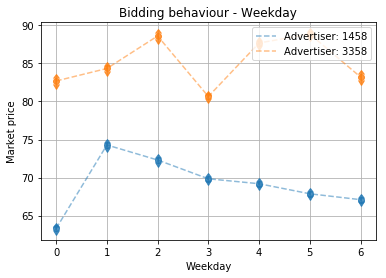

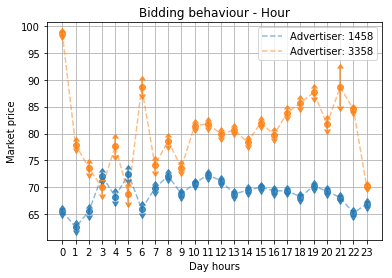

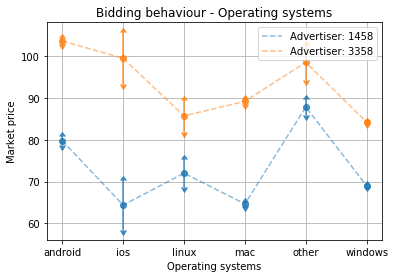

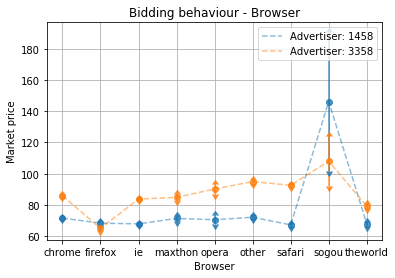

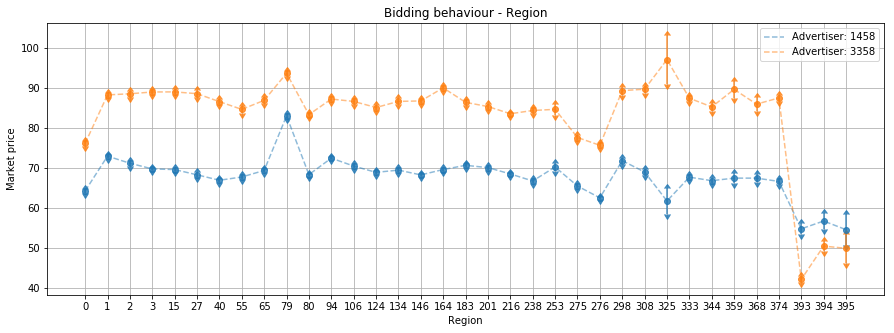

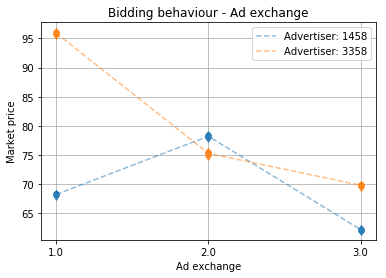

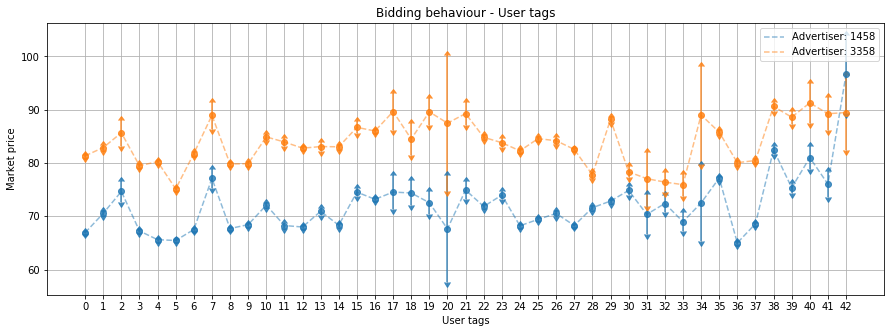

In [10]:
#Bidding behaviour.
print('• Bidding behaviour (Market price):\n')

#Weekday.
plt.title('Bidding behaviour - Weekday')
plt.xlabel('Weekday')
plt.ylabel('Market price')

plt.errorbar(Dict_day[Adv1].values(), Matrix_day[Adv1][1], yerr=Matrix_day_err[Adv1][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_day[Adv1].values(), Matrix_day[Adv1][1], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_day[Adv2].values(), Matrix_day[Adv2][1], yerr=Matrix_day_err[Adv2][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_day[Adv2].values(), Matrix_day[Adv2][1], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_day[Adv1])), Dict_day[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Day hours.
plt.title('Bidding behaviour - Hour')
plt.xlabel('Day hours')
plt.ylabel('Market price')

plt.errorbar(Dict_hour[Adv1].values(), Matrix_hour[Adv1][1], yerr=Matrix_hour_err[Adv1][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_hour[Adv1].values(), Matrix_hour[Adv1][1], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_hour[Adv2].values(), Matrix_hour[Adv2][1], yerr=Matrix_hour_err[Adv2][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_hour[Adv2].values(), Matrix_hour[Adv2][1], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_hour[Adv1])), Dict_hour[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Operating systems.
plt.title('Bidding behaviour - Operating systems')
plt.xlabel('Operating systems')
plt.ylabel('Market price')

plt.errorbar(Dict_OS[Adv1].values(), Matrix_OS[Adv1][1], yerr=Matrix_OS_err[Adv1][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_OS[Adv1].values(), Matrix_OS[Adv1][1], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_OS[Adv2].values(), Matrix_OS[Adv2][1], yerr=Matrix_OS_err[Adv2][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_OS[Adv2].values(), Matrix_OS[Adv2][1], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_OS[Adv1])), Dict_OS[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Browser.
plt.title('Bidding behaviour - Browser')
plt.xlabel('Browser')
plt.ylabel('Market price')

plt.errorbar(Dict_brw[Adv1].values(), Matrix_brw[Adv1][1], yerr=Matrix_brw_err[Adv1][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_brw[Adv1].values(), Matrix_brw[Adv1][1], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_brw[Adv2].values(), Matrix_brw[Adv2][1], yerr=Matrix_brw_err[Adv2][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_brw[Adv2].values(), Matrix_brw[Adv2][1], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_brw[Adv1])), Dict_brw[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Region.
plt.figure(figsize=(15,5))
plt.title('Bidding behaviour - Region')
plt.xlabel('Region')
plt.ylabel('Market price')

plt.errorbar(Dict_reg[Adv1].values(), Matrix_reg[Adv1][1], yerr=Matrix_reg_err[Adv1][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_reg[Adv1].values(), Matrix_reg[Adv1][1], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_reg[Adv2].values(), Matrix_reg[Adv2][1], yerr=Matrix_reg_err[Adv2][1], marker='o', fmt='o',
             lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_reg[Adv2].values(), Matrix_reg[Adv2][1], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_reg[Adv1])), Dict_reg[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Slot ad exchange.
plt.title('Bidding behaviour - Ad exchange')
plt.xlabel('Ad exchange')
plt.ylabel('Market price')

plt.errorbar(Dict_adexc[Adv1].values(), Matrix_adexc[Adv1][1], yerr=Matrix_adexc_err[Adv1][1], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_adexc[Adv1].values(), Matrix_adexc[Adv1][1], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_adexc[Adv2].values(), Matrix_adexc[Adv2][1], yerr=Matrix_adexc_err[Adv2][1], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_adexc[Adv2].values(), Matrix_adexc[Adv2][1], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_adexc[Adv1])), Dict_adexc[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#User tags.
plt.figure(figsize=(15,5))
plt.title('Bidding behaviour - User tags')
plt.xlabel('User tags')
plt.ylabel('Market price')

plt.errorbar(Dict_tag[Adv1].values(), Matrix_tag[Adv1][1], yerr=Matrix_tag_err[Adv1][1], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#1f77b4')
plt.plot(Dict_tag[Adv1].values(), Matrix_tag[Adv1][1], '--', alpha=0.5, color = '#1f77b4', label = Label1)

plt.errorbar(Dict_tag[Adv2].values(), Matrix_tag[Adv2][1], yerr=Matrix_tag_err[Adv2][1], marker='o',
             fmt='o', lolims=True, uplims=True, alpha=0.8, color = '#ff7f0e')
plt.plot(Dict_tag[Adv2].values(), Matrix_tag[Adv2][1], '--', alpha=0.5, color = '#ff7f0e', label = Label2)

plt.xticks(np.arange(0,len(Dict_tag[Adv1])), Dict_tag[Adv1].values())
plt.legend(loc=1)
plt.grid()
plt.show()

Expected cost per click (eCPC).

• Expected cost per click (eCPC).


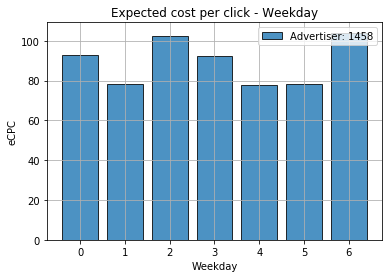

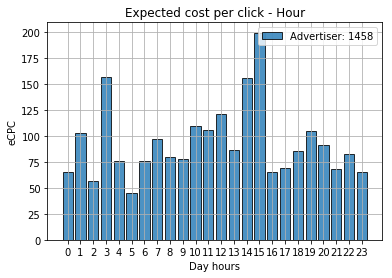

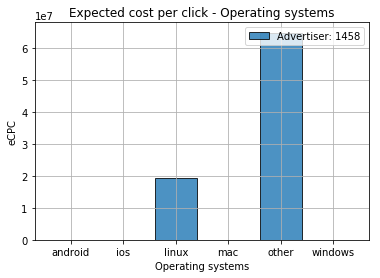

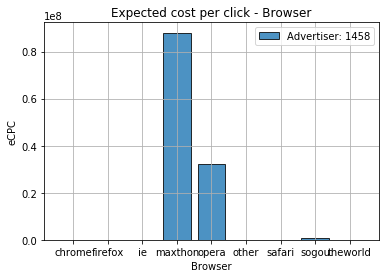

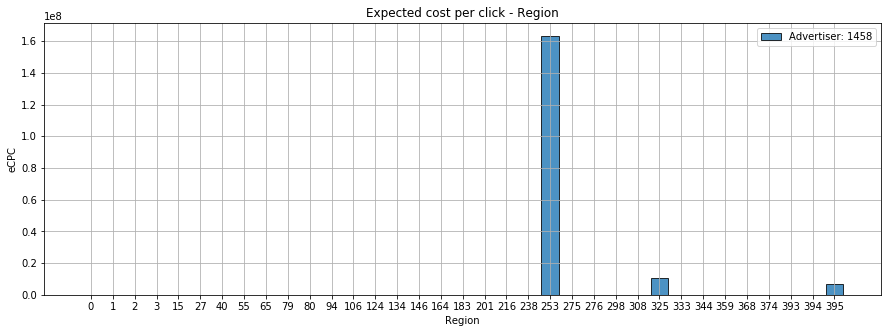

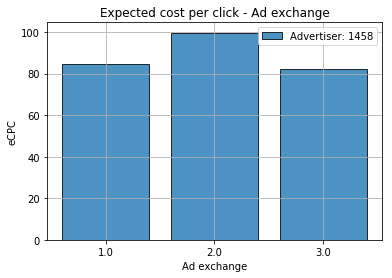

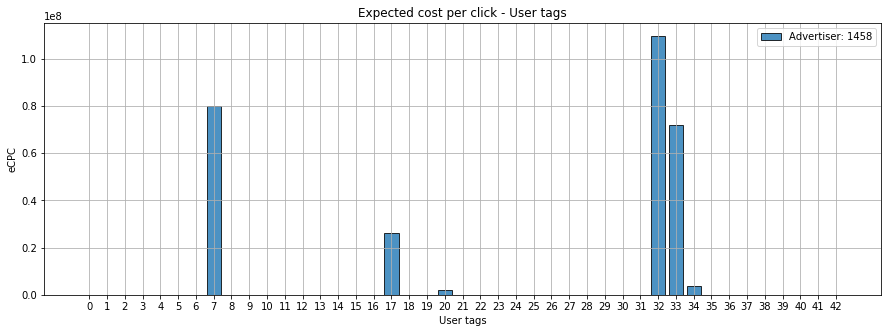

In [11]:
#Expected cost per click (eCPC).
print('• Expected cost per click (eCPC).')
Adv1 = 1458
Label1 = 'Advertiser: ' + str(Adv1)

#Weekday.
plt.title('Expected cost per click - Weekday')
plt.xlabel('Weekday')
plt.ylabel('eCPC')

plt.bar(Dict_day[Adv1].values(), Matrix_day[Adv1][2], width=0.8, align='center', alpha=0.8, 
        edgecolor = "black", color = '#1f77b4', label = Label1)

plt.xticks(np.arange(0,len(Dict_day[Adv1])), Dict_day[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Day hours.
plt.title('Expected cost per click - Hour')
plt.xlabel('Day hours')
plt.ylabel('eCPC')

plt.bar(Dict_hour[Adv1].values(), Matrix_hour[Adv1][2], width=0.8, align='center', alpha=0.8, 
        edgecolor = "black", color = '#1f77b4', label = Label1)

plt.xticks(np.arange(0,len(Dict_hour[Adv1])), Dict_hour[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Operating systems.
plt.title('Expected cost per click - Operating systems')
plt.xlabel('Operating systems')
plt.ylabel('eCPC')

plt.bar(Dict_OS[Adv1].values(), Matrix_OS[Adv1][2], width=0.8, align='center', alpha=0.8, 
        edgecolor = "black", color = '#1f77b4', label = Label1)
    
plt.xticks(np.arange(0,len(Dict_OS[Adv1])), Dict_OS[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Browser.
plt.title('Expected cost per click - Browser')
plt.xlabel('Browser')
plt.ylabel('eCPC')

plt.bar(Dict_brw[Adv1].values(), Matrix_brw[Adv1][2], width=0.8, align='center', alpha=0.8, 
        edgecolor = "black", color = '#1f77b4', label = Label1)

plt.xticks(np.arange(0,len(Dict_brw[Adv1])), Dict_brw[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Region.
plt.figure(figsize=(15,5))
plt.title('Expected cost per click - Region')
plt.xlabel('Region')
plt.ylabel('eCPC')

plt.bar(Dict_reg[Adv1].values(), Matrix_reg[Adv1][2], width=0.8, align='center', alpha=0.8, 
        edgecolor = "black", color = '#1f77b4', label = Label1)

plt.xticks(np.arange(0,len(Dict_reg[Adv1])), Dict_reg[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#Slot ad exchange.
plt.title('Expected cost per click - Ad exchange')
plt.xlabel('Ad exchange')
plt.ylabel('eCPC')

plt.bar(Dict_adexc[Adv1].values(), Matrix_adexc[Adv1][2], width=0.8, align='center', alpha=0.8, 
        edgecolor = "black", color = '#1f77b4', label = Label1)

plt.xticks(np.arange(0,len(Dict_adexc[Adv1])), Dict_adexc[Adv1].keys())
plt.legend(loc=1)
plt.grid()
plt.show()

#User tags.
plt.figure(figsize=(15,5))
plt.title('Expected cost per click - User tags')
plt.xlabel('User tags')
plt.ylabel('eCPC')

plt.bar(Dict_tag[Adv1].values(), Matrix_tag[Adv1][2], width=0.8, align='center', alpha=0.8, 
        edgecolor = "black", color = '#1f77b4', label = Label1)

plt.xticks(np.arange(0,len(Dict_tag[Adv1])), Dict_tag[Adv1].values())
plt.legend(loc=1)
plt.grid()
plt.show()